In [1]:
import torch
from transformers import BertTokenizer
from transformers import BertModel, BertConfig, BertForSequenceClassification
from tqdm.autonotebook import tqdm
import pandas as pd
import numpy as np
tqdm.pandas()

c:\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
labeled_test_df = pd.read_pickle('test_data_unseen_bert_without_addl_data.zip', compression='zip')
print(len(labeled_test_df))

315


In [3]:
test_text_list = labeled_test_df['summary'].tolist()
test_labels = np.array(labeled_test_df['label'].tolist())

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

In [5]:
BERT_MODEL = 'scdb_train_tuned_model_without_addl_data'
num_labels = 14
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=False)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=num_labels)

In [6]:
device = torch.device('cuda')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [7]:
# Default MAX sequence length for BertModel
MAX_SEQ_LENGTH = 128
def pad_sequences(pad_token, seq_list, max_length):
    return seq_list + [pad_token] * (max_length - len(seq_list))

def pad_special_tokens(tokenized_text_sent):
    if len(tokenized_text_sent) > MAX_SEQ_LENGTH - 2:
           tokenized_text_sent = tokenized_text_sent[0:(MAX_SEQ_LENGTH - 2)]            
    tokenized_text_sent.insert(0,'[CLS]')
    tokenized_text_sent.append('[SEP]')
    return tokenized_text_sent

def tokenize_sentence(summary_text): 
    tokenized_text_sent = tokenizer.tokenize(summary_text[0]['summary_text'])                  
    tokenized_text_sent = pad_special_tokens(tokenized_text_sent)
    return tokenized_text_sent  

tokenized_seq = list(map(tokenize_sentence, test_text_list))
print(tokenized_seq[0])

['[CLS]', 'B', '##U', '##LL', '##OC', '##K', 'v', '.', 'South', 'Carolina', ',', 'No', '.', '78', ',', 'February', '20', ',', '1961', '.', 'Report', '##ed', 'below', ':', '235', 'S', '.', 'C', '.', '35', '##6', ',', '111', 'S', '.', 'E', '.', '2d', '65', '##7', '.', 'U', '.', 'S', '.', 'Supreme', 'Court', ':', '"', 'The', 'w', '##rit', 'of', 'c', '##ert', '##ior', '##ari', 'is', 'dismissed', '.', 'The', 'total', '##ity', 'of', 'circumstances', 'as', 'the', 'record', 'makes', 'them', 'manifest', 'did', 'not', 'warrant', 'bringing', 'this', 'case', 'here', ',', 'and', 'the', 'w', '##rit', 'of', '##cer', '##ti', '##ora', '##ri', 'was', 'dismissed', '"', 'The', 'case', 'was', 'decided', 'by', 'a', 'vote', 'of', '5', '-', '3', '.', 'The', 'decision', 'was', 'the', 'first', 'of', 'its', 'kind', 'in', 'the', 'Supreme', 'Court', 'of', 'the', 'United', 'States', '.', 'The', 'case', 'is', 'part', 'of', 'a', 'series', '[SEP]']


In [8]:
def convert_tokens_to_tensor(tokenized_sentence_a):        
    tokenized_text = []
    tokenized_text.extend(tokenized_sentence_a)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    indexed_tokens = pad_sequences(0, indexed_tokens, MAX_SEQ_LENGTH)    
    tokens_tensor = torch.tensor([indexed_tokens], device=device)
    #generate the token type ids
    token_type_ids = []
    token_type_a = [0] * len(tokenized_sentence_a)
    token_type_ids.extend(token_type_a)
    token_type_ids = pad_sequences(0, token_type_ids, MAX_SEQ_LENGTH)    
    token_type_tensor = torch.tensor([token_type_ids],device=device)
    #generate the type ids
    input_mask = [1] * len(tokenized_text)
    input_mask = pad_sequences(0, input_mask, MAX_SEQ_LENGTH)    
    input_tensor = torch.tensor([input_mask],device=device)
    return [tokens_tensor, token_type_tensor, input_tensor]    

converted_tensors = list(map(convert_tokens_to_tensor, tokenized_seq))
print(converted_tensors[0])

[tensor([[  101,   139,  2591, 23955,  9244,  2428,   191,   119,  1375,  2938,
           117,  1302,   119,  5603,   117,  1428,  1406,   117,  2920,   119,
          7178,  1174,  2071,   131, 19152,   156,   119,   140,   119,  2588,
          1545,   117, 11084,   156,   119,   142,   119, 25712,  2625,  1559,
           119,   158,   119,   156,   119,  3732,  2031,   131,   107,  1109,
           192,  7729,  1104,   172,  7340, 18472,  7710,  1110,  6714,   119,
          1109,  1703,  1785,  1104,  5607,  1112,  1103,  1647,  2228,  1172,
         23487,  1225,  1136, 13178,  4362,  1142,  1692,  1303,   117,  1105,
          1103,   192,  7729,  1104, 14840,  3121,  6533,  2047,  1108,  6714,
           107,  1109,  1692,  1108,  1879,  1118,   170,  2992,  1104,   126,
           118,   124,   119,  1109,  2383,  1108,  1103,  1148,  1104,  1157,
          1912,  1107,  1103,  3732,  2031,  1104,  1103,  1244,  1311,   119,
          1109,  1692,  1110,  1226,  1104,   170, 

In [9]:
from tqdm import tqdm_notebook, trange

predictions = []
for predict_record in converted_tensors:
    outputs = model(predict_record[0], token_type_ids=predict_record[1], attention_mask=predict_record[2])
    prediction = np.argmax(outputs[0][0].cpu().detach().numpy())
    predictions.append(prediction)


In [10]:
from sklearn import svm
from sklearn.metrics import classification_report
cr = classification_report(test_labels, predictions)
print(cr)

              precision    recall  f1-score   support

         1.0       0.82      0.87      0.85       161
         2.0       0.57      0.67      0.62        30
         3.0       0.65      0.55      0.60        31
         4.0       0.45      0.31      0.37        16
         5.0       0.50      0.50      0.50         2
         6.0       0.00      0.00      0.00         3
         7.0       0.00      0.00      0.00         1
         8.0       0.67      0.67      0.67        24
         9.0       0.41      0.38      0.39        32
        10.0       0.50      0.20      0.29         5
        11.0       0.33      0.50      0.40         2
        12.0       0.60      0.86      0.71         7
        13.0       0.00      0.00      0.00         1

    accuracy                           0.70       315
   macro avg       0.42      0.42      0.41       315
weighted avg       0.68      0.70      0.69       315



c:\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.84592145 0.61538462 0.59649123 0.37037037 0.5        0.
 0.         0.66666667 0.39344262 0.28571429 0.4        0.70588235
 0.         0.41383643 0.68518082]
[161  30  31  16   2   3   1  24  32   5   2   7   1 315 315]
0.5947326889265513


c:\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\dc_stat_think\dc_stat_think.py:498: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_draw_bs_pairs" failed type inference due to: Invalid use of type(CPUDispatcher(<function _make_two_arg_numba_func.<locals>.f at 0x0000023681FBD708>)) with parameters (array(float64, 1d, C), array(float64, 1d, C), Tuple())
 * parameterized
[1] During: resolving callee type: type(CPUDispatcher(<function _make_two_arg_numba_func.<locals>.f at 0x0000023681FBD708>))
[2] During: typing of call at c:\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\dc_stat_think\dc_stat_think.py (510)


File "..\..\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\dc_stat_think\dc_stat_think.py", line 510:
    def _draw_bs_pairs(x, y):
        <source elided>
            bs_x, bs_y = x[bs_inds], y[bs_inds]
            bs_replicates[i] = f(bs_x, bs_y, args)
            ^

  @numba.jit
c:\users\u0155811\.conda\envs\t

[0.43106837 0.74476862]
0.5968977238078704
0.0008330890442518795


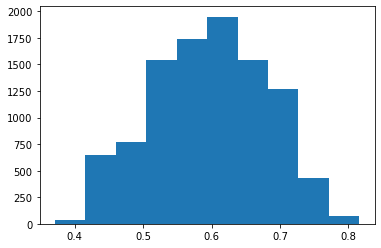

In [11]:
import ast
from scipy import stats
import dc_stat_think as dcst
import numpy as np
import matplotlib.pyplot as plt
# Add the label 13 which was missed in the splits
f1_score_list = []
support =[]
cr_dict = classification_report(test_labels, predictions, output_dict=True)
for cr_value_dict in cr_dict.values():
    if isinstance(cr_value_dict, dict):
        f1_score_list.append(cr_value_dict['f1-score'])
        support.append(cr_value_dict['support'])
f1_score_np = np.array(f1_score_list)
support_np = np.array(support)
#Bootstrap sampling to calculate the confidence interval for f1-score
def weighted_average(x, y):
    return np.sum(x * y)/np.sum(y)

def boostrap_weighted_avg(data,size):
    return dcst.draw_bs_pairs(data, support, weighted_average, size=size)
   
print(f1_score_np)    
print(support_np)
print(weighted_average(f1_score_np, support_np))
bs_weighted_avg = boostrap_weighted_avg(f1_score_np, 10000)
print(np.percentile(bs_weighted_avg, [2.5, 97.5]))
print(np.mean(bs_weighted_avg))
print(stats.sem(bs_weighted_avg, axis=None, ddof=0))
plt.hist(bs_weighted_avg)
plt.show()